In [1]:
import glob
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/skin_2.zip"

In [4]:
for i in os.listdir("/content/skin_2"):
  try:
    c = len(os.listdir(os.path.join("/content/skin_2",i)))
    print(i+": "+str(c))
  except:
    pass

Nail_psoriasis: 1080
hyperpigmentation: 300
Vitiligo: 864
acne: 492
SJS-TEN: 1356


**`We have five types of disease image data but the problem is data is imbalance specially for "acne" has 492 data and "hyperpigmentation" has 300 data `**

### **So I decided to augment the data for making it balance **

`Our average data size is more than 800 so we will make acne and hyperpigmentation more than 800 `



1.   **`For acne we need augment every data for one more time`**
2.   **`For hyperpigmentation we need to augment every data for 2 more times`**




In [5]:
#Augmantation of acne data

import cv2
from skimage.exposure import rescale_intensity
from skimage.segmentation import slic
from skimage.util import img_as_float
from skimage import io
import numpy as np


def gausian_blur(image,blur):
    image = cv2.GaussianBlur(image,(5,5),blur)
    cv2.imwrite(Folder_name+"/GausianBLur-"+str(blur)+Extension, image)

def averageing_blur(image,shift):
    image=cv2.blur(image,(shift,shift))
    cv2.imwrite(Folder_name + "/AverageingBLur-" + str(shift) + Extension, image)

def median_blur(image,shift):
    image=cv2.medianBlur(image,shift)
    cv2.imwrite(Folder_name + "/MedianBLur-" + str(shift) + Extension, image)

def bileteralBlur(image,d,color,space):
    image = cv2.bilateralFilter(image, d,color,space)
    cv2.imwrite(Folder_name + "/BileteralBlur-"+str(d)+"*"+str(color)+"*"+str(space)+ Extension, image)


In [ ]:
#augmenting acne data
import os
folder_path = "/content/skin_2/acne"
for img in os.listdir(folder_path):
    simg_path = os.path.join(folder_path,img)
    print(simg_path)
    
    
    image_file=simg_path
    Folder_name=folder_path
    Extension=image_file.split("/")[-1]
    image=cv2.imread(image_file)

    # gausian_blur(image,0.25)
    gausian_blur(image,0.50)



In [7]:
for i in os.listdir("/content/skin_2"):
  try:
    c = len(os.listdir(os.path.join("/content/skin_2",i)))
    print(i+": "+str(c))
  except:
    pass

Nail_psoriasis: 1080
hyperpigmentation: 300
Vitiligo: 864
acne: 984
SJS-TEN: 1356


In [ ]:
#augmenting hyperpigmentation data
import os
folder_path = "/content/skin_2/hyperpigmentation"
for img in os.listdir(folder_path):
    simg_path = os.path.join(folder_path,img)
    print(simg_path)
    
    
    image_file=simg_path
    Folder_name=folder_path
    Extension=image_file.split("/")[-1]
    image=cv2.imread(image_file)

    gausian_blur(image,0.25)
    gausian_blur(image,0.50)

In [9]:
for i in os.listdir("/content/skin_2"):
  try:
    c = len(os.listdir(os.path.join("/content/skin_2",i)))
    print(i+": "+str(c))
  except:
    pass

Nail_psoriasis: 1080
hyperpigmentation: 900
Vitiligo: 864
acne: 984
SJS-TEN: 1356


Transfer Learning

In [10]:
#Import different kinds of library
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [12]:
#Load the dataset the JPES files what we converted before
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/skin_2',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5184 files belonging to 5 classes.


In [13]:
#Class name in my dataset
class_name=dataset.class_names
class_name


['Nail_psoriasis', 'SJS-TEN', 'Vitiligo', 'acne', 'hyperpigmentation']

In [14]:
#image shape 
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 4 1 4 4 1 0 1 2 1 0 0 4 3 4 3 1 3 0 4 0 0 3 3 1 3 2 0 4 1 2 0]


In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())


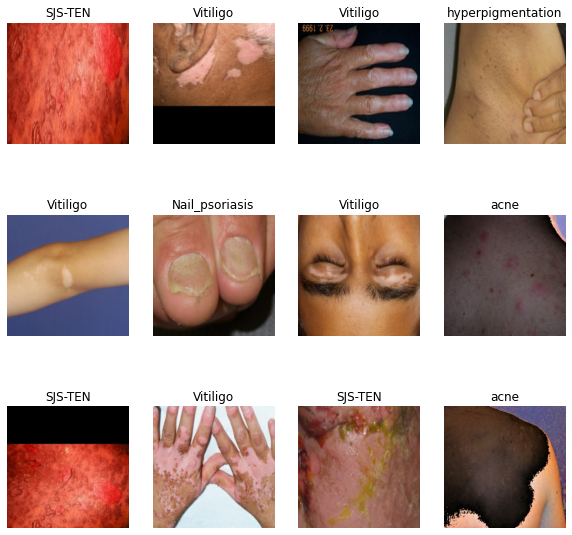

In [16]:
#some data visualization for understanding
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_name[labels_batch[i]])
    plt.axis("off")

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
# data_augmentation = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#   layers.experimental.preprocessing.RandomRotation(0.2),
# ])


#Resnet50 model
conv_base = ResNet50(
    include_top=False,
    weights='imagenet')


for layer in conv_base.layers:
    layer.trainable = False


x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(5, activation='softmax')(x)
model = Model(conv_base.input, predictions)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


94781440/94765736 [==============================] - 1s 0us/step


In [22]:
#Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=3
)

Epoch 1/3
113/113 [==============================] - 720s 6s/step - loss: 0.4857 - accuracy: 0.8258 - val_loss: 0.1572 - val_accuracy: 0.9541
Epoch 2/3
113/113 [==============================] - 705s 6s/step - loss: 0.0982 - accuracy: 0.9737 - val_loss: 0.0570 - val_accuracy: 0.9912
Epoch 3/3
113/113 [==============================] - 707s 6s/step - loss: 0.0447 - accuracy: 0.9906 - val_loss: 0.0453 - val_accuracy: 0.9912


In [23]:
#Testing the model
scores = model.evaluate(test_ds)

17/17 [==============================] - 92s 5s/step - loss: 0.0568 - accuracy: 0.9835


first image to predict
actual label: SJS-TEN
predicted label: SJS-TEN


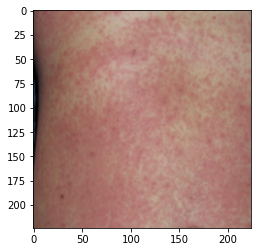

In [26]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[-1].numpy().astype('uint8')
    first_label = labels_batch[-1].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

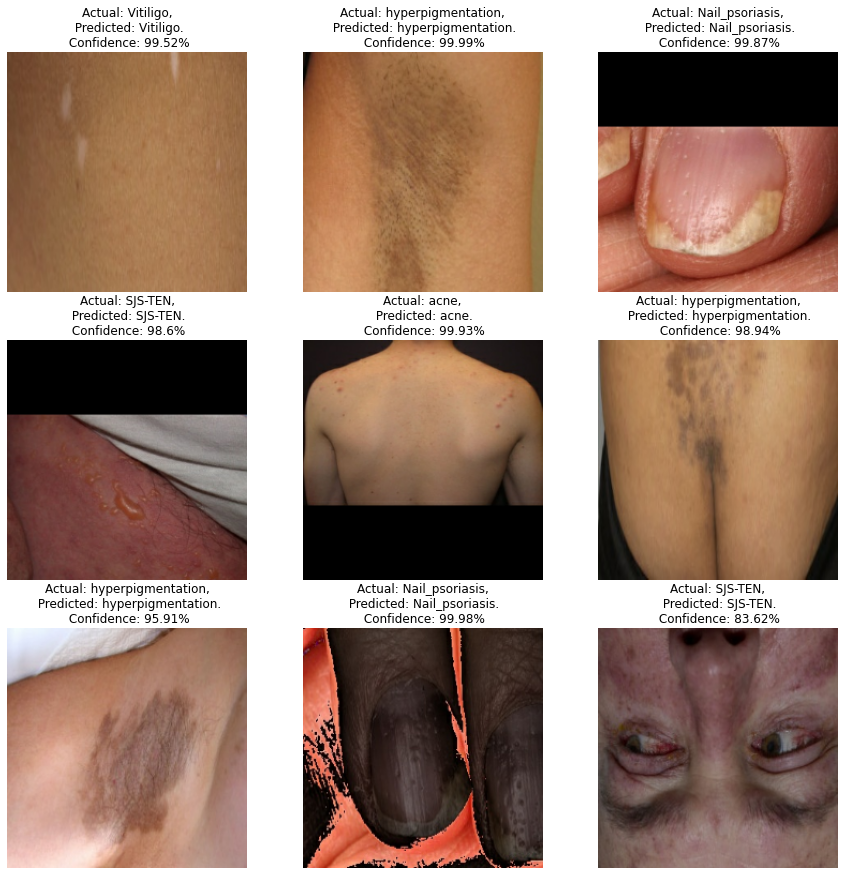

In [31]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence =predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

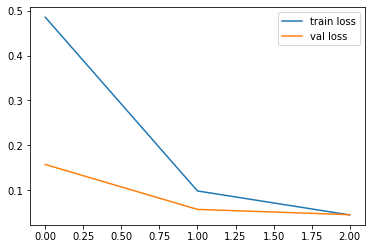

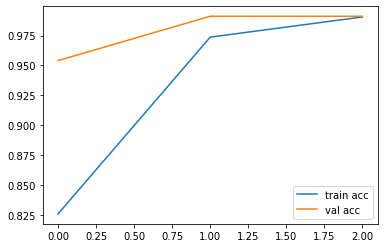

<Figure size 432x288 with 0 Axes>

In [32]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
predicted = []
actual = []
for images, labels in test_ds:
  for i in range(32):
    predicted_class, confidence =predict(model, images[i].numpy())
    predicted.append(predicted_class)
    actual.append(class_name[labels[i]])
    print(predicted_class,class_name[labels[i]])


In [34]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(actual, predicted)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))


precision: [1.         0.99328859 0.9375     0.99090909 0.98809524]
recall: [1.         0.94871795 0.98901099 1.         1.        ]
fscore: [1.         0.9704918  0.96256684 0.99543379 0.99401198]


In [35]:
#creating the confusion matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

con_matrix = confusion_matrix(actual, predicted)
con_matrix

array([[105,   0,   0,   0,   0],
       [  0, 148,   6,   1,   1],
       [  0,   1,  90,   0,   0],
       [  0,   0,   0, 109,   0],
       [  0,   0,   0,   0,  83]])

In [36]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
  import matplotlib.pyplot as plt
  import numpy as np
  import itertools

  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
      cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
      tick_marks = np.arange(len(target_names))
      plt.xticks(tick_marks, target_names, rotation=45)
      plt.yticks(tick_marks, target_names)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="black" if cm[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="black" if cm[i, j] > thresh else "black")


  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()

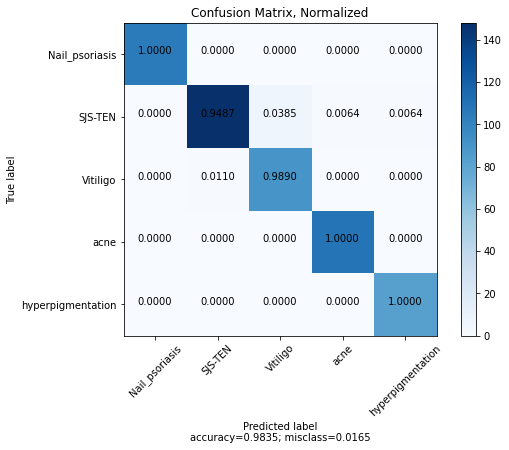

In [37]:
plot_confusion_matrix(cm           = con_matrix, 
                      normalize    = True,
                      target_names = class_name,
                      title        = "Confusion Matrix, Normalized")